In [117]:
import geopandas as gpd
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.visualization import ee_viz
from src.data import mtbs
from src.data import shape_processor
from src.data import gedi_pipeline
from src.data import k_nn
from src.constants import DATA_PATH, USER_PATH
import ee
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from fitter import Fitter, get_common_distributions, get_distributions
from src.processing.recent_fires import gedi_matching, matching_analysis
from src.visualization.gedi_viz import geo_plot
from src.data import fire_perimeters
sns.set_theme()

import importlib
importlib.reload(gedi_pipeline)
importlib.reload(gedi_matching)
importlib.reload(matching_analysis)
importlib.reload(fire_perimeters)
from src.data.gedi_pipeline import get_severity
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB

2023-06-18 16:26:38,252 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-18 16:26:38,256 DEBUG: Logger /home/jk871/fire-regen/src/data/fire_perimeters.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


In [90]:
def get_matches(df, distance):
    return df[df.closest_distance < distance]

### Find before and after matches on areas that did not burn

Since we're using this as the control for our GEDI matching algorithm, there is no
disturbance date, as these are unburned regions. As such, we choose the date '01-01-2021" as the boundary between
"before" and "after" shots. 

We operate under the assumption that these forests are slow growing - hence the 
year-to-year carbon change is insignificant, and that the forests did not experience other major disturbances.
If these assumptions were correct, and gedi matching algorithm was appropriate, we'd
expect to see comparable AGBD measurements on before and after matches.

Of course, it's likely that our assumptions are not perfectly correct, so there will be some 
difference between before and after.

We will try to quantify this difference with respect to the y = x line, where before_agbd = after_agbd, and measure
R squared error compared to that prediction

In [18]:
gedi_burned, gedi_unburned = gedi_pipeline.load_stage_5(3)

In [19]:
matches = gedi_matching.match_measurements_before_and_after_date("01-01-2021", gedi_unburned, 'agbd')

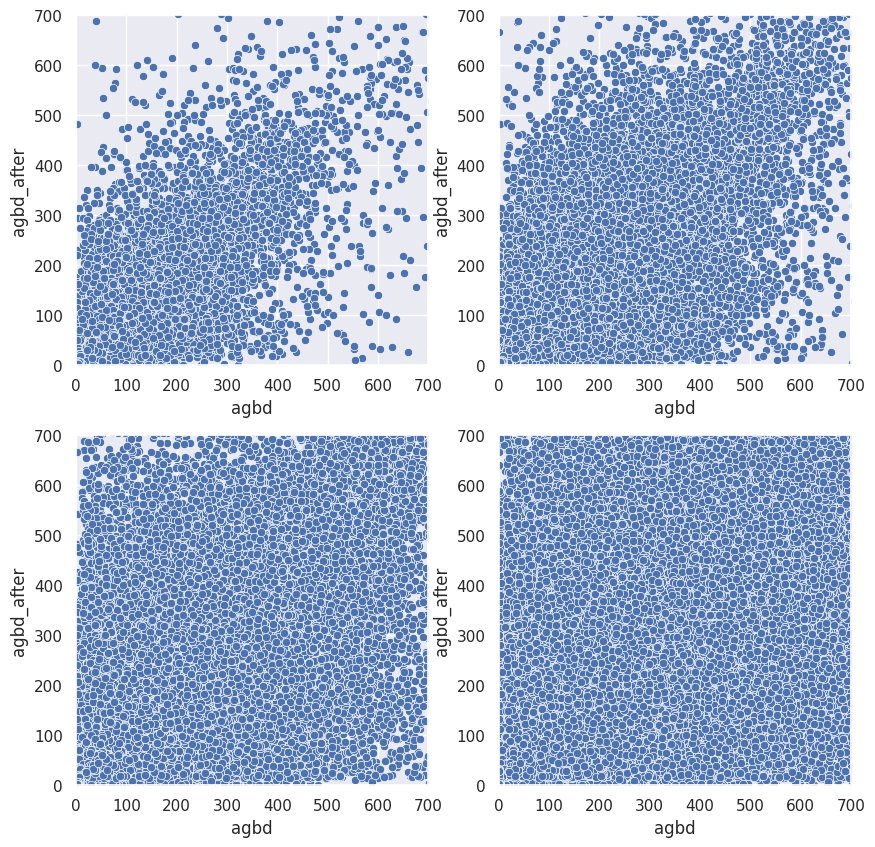

In [20]:
matching_analysis.plot_for_distance(matches, 'agbd')

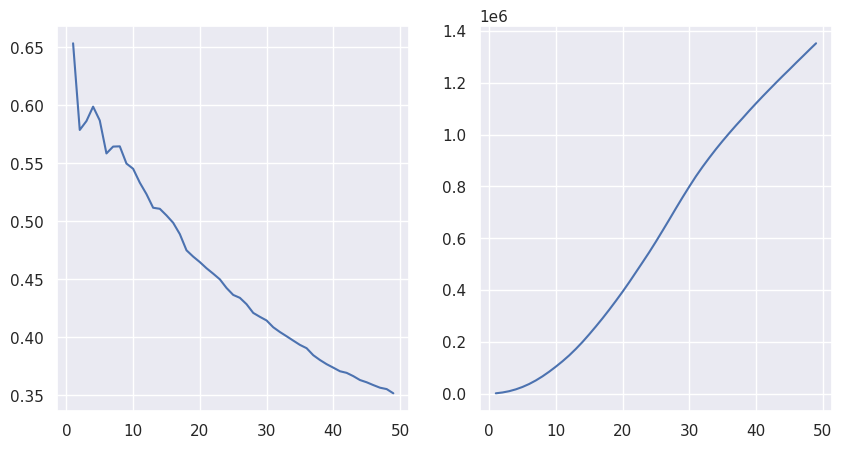

In [21]:
matching_analysis.plot_control_error_for_distances(matches, 'agbd')

Best Linear regression coefficient is [0.76824845].         R squared is : 0.5959173304355856.
The error for coeff = 1 is: 0.5454242271350829.


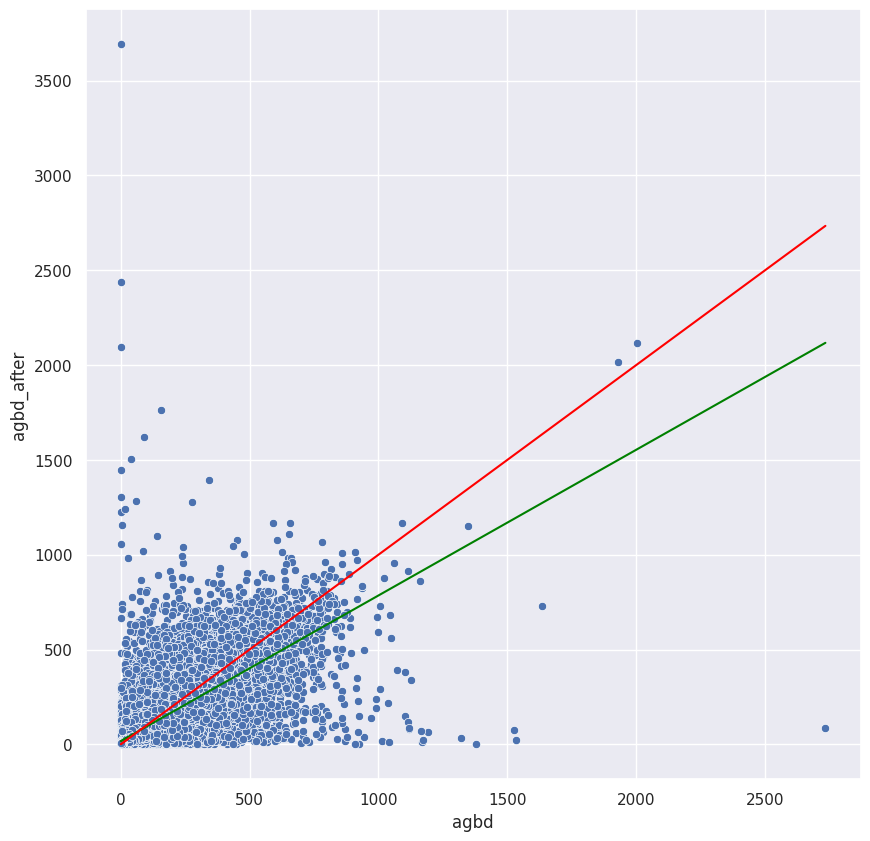

In [22]:
matching_analysis.fit_linear_regression(matches[matches.closest_distance < 10], 'agbd')

In [88]:
closest_matches_uburned_20 = matches[matches.closest_distance < 20]
closest_matches_uburned_10 = matches[matches.closest_distance < 10]

(-300.0, 300.0)

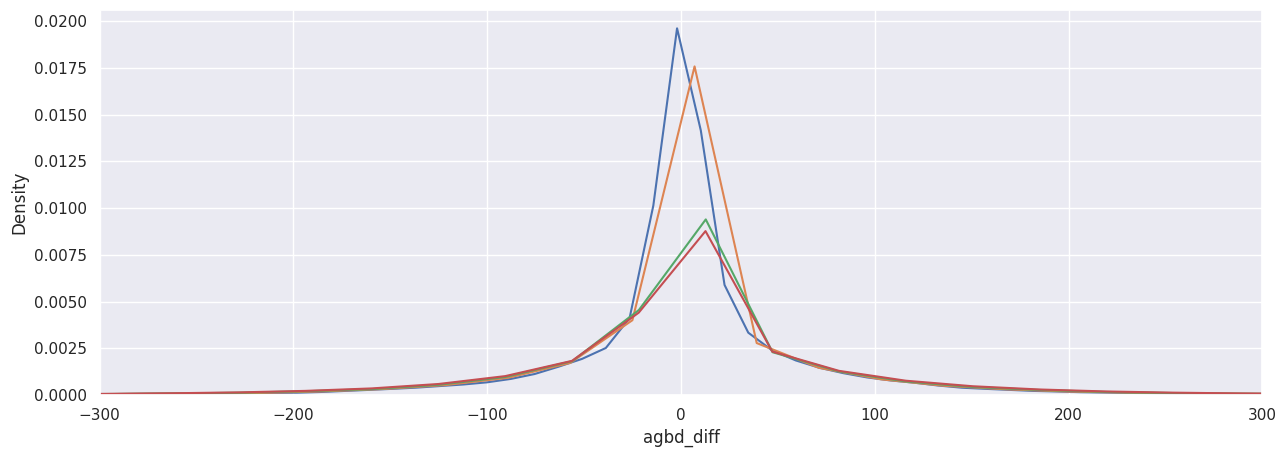

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.kdeplot(get_matches(matches, 5), x="agbd_diff", ax=ax)
sns.kdeplot(get_matches(matches, 10), x="agbd_diff", ax=ax)
sns.kdeplot(get_matches(matches, 20), x="agbd_diff", ax=ax)
sns.kdeplot(get_matches(matches, 30), x="agbd_diff", ax=ax)
ax.set_xlim((-300, 300))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(closest_matches, x="agbd_diff", ax=ax)
ax.set_xlim((-500, 500))

(0.0, 3.0)

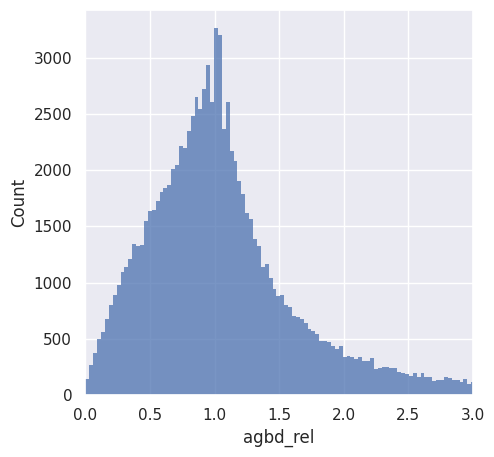

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.histplot(closest_matches, x="agbd_rel", ax=ax)
ax.set_xlim((0, 3))
#ax.set_xlim((-500, 500))

Fitting 5 distributions: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


         sumsquare_error           aic            bic  kl_div  ks_statistic  \
beta            0.000203  1.048902e+04 -476461.420185     inf      0.186308   
lognorm         0.000204  1.022087e+04 -476428.776535     inf      0.186938   
norm            0.000204  1.091123e+04 -476407.928208     inf      0.185281   
gamma           0.000215           inf -474993.002819     inf      0.318717   
burr            0.000301  1.617339e+04 -466404.076464     inf      0.295114   

         ks_pvalue  
beta           0.0  
lognorm        0.0  
norm           0.0  
gamma          0.0  
burr           0.0  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 27.93it/s]


{'norm': {'loc': 3.598100864688944, 'scale': 71.65349961023986}}


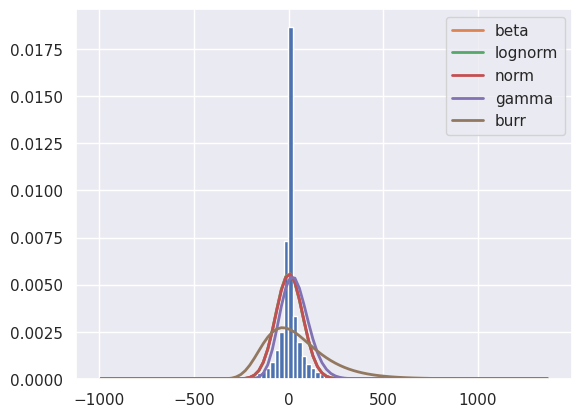

In [93]:
# Best fit for the distribution of "agbd_diff" is normal with mean = 2.93 and std=76.9
matching_analysis.fit_distributions(get_matches(matches, 5), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


         sumsquare_error           aic           bic  kl_div  ks_statistic  \
beta            0.000034  6.054319e+04 -2.270575e+06     inf      0.189434   
norm            0.000034  6.230048e+04 -2.270445e+06     inf      0.189233   
burr            0.000088  6.463322e+05 -2.172571e+06     inf      0.416756   
lognorm         0.000126           inf -2.135519e+06     inf      0.824858   
gamma           0.041694           inf -1.532121e+06     inf      0.999277   

         ks_pvalue  
beta           0.0  
norm           0.0  
burr           0.0  
lognorm        0.0  
gamma          0.0  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 24.35it/s]


{'norm': {'loc': 2.926682398836867, 'scale': 76.90974156083534}}


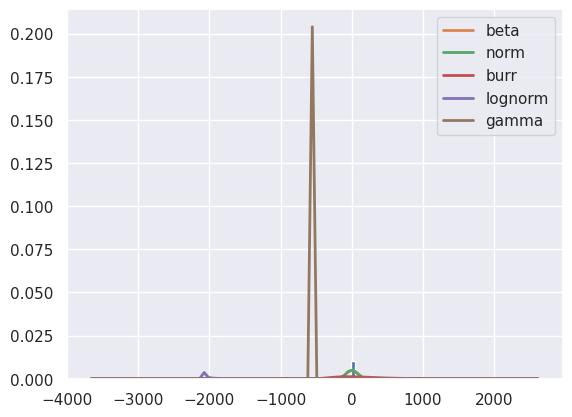

In [94]:
matching_analysis.fit_distributions(get_matches(matches, 10), 'agbd')

### Analysis on all aggregated fires 2019-2022.

In [39]:
sierras_complex = gpd.read_file(f"{USER_PATH}/data/shapefiles/sierras.shp")
sierras_box = shape_processor.get_box(sierras_complex)
sierras = gpd.read_file(f"{USER_PATH}/data/shapefiles/sierras_convex_hull.shp")

In [40]:
# Get MTBS fire perimeters.
mtbs_perimeters = fire_perimeters.MTBSFirePerimetersDB(sierras)

In [52]:
mtbs_perimeters.perimeters[mtbs_perimeters.perimeters.Ig_Date > '01-01-2019'].shape[0]

54

In [50]:
firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2019', '2020', '2021', '2022']).filter_within_geometry(sierras)

There are two sources of fire perimeters: MTBS and CalFire. 

MTBS has fires from 1982-2022 that ae over 1000 acres, and those are the ones on which we have severity data. The problem is,
that database only has ignition date, but not containment date. So when we want to calculate before and after carbon differences, it's harded to account for the "after" date.

On the other hand, CalFire has big and small fires, and ignition and containment dates. But, we only have severity data on fires larger than 1000 acres.

Hence, we will use CalFire dataset, but filtered for larger fires over 1000 acres.

In [53]:
sierra_firep.filter_for_fires_over_1000_acres()

Additionally, at the time of this writing, MTBS does not include severity of one 
of the largest fires that happened in the last few years - Dixie. Because we 
don't have severity data about it, we will exclude it from this analysis.

In [60]:
sierra_firep.perimeters = sierra_firep.perimeters[sierra_firep.perimeters.FIRE_NAME!="DIXIE"]

In [61]:
sierra_firep.perimeters.shape[0]

54

### Matches in recent fires

First, we look at matches in 3x3 filtered regions - these are more high-quality shots, but there is fewer of them.

We're loading stage 4 of the gedi pipeline, because these are the shots that 
have been filtered for the areas that burned, but were not further filtered for 
regrowth analysis. (For regrowth, we exclude all gedi shots that happened before fire, so 
we wouldn't be able to do this kind of analysis).

In [71]:
gedi_burned_3x3, gedi_unburned_3x3 = gedi_pipeline.load_stage_4(3)

In [72]:
burn_agbd_matches_3x3 = gedi_matching.match_across_fire_perimeters(sierra_firep.perimeters, gedi_burned_3x3, 'agbd')

Skipped fire GRADE. No matching GEDI shots found.
Skipped fire FORK. No matching GEDI shots found.
Skipped fire BLUEJAY. No matching GEDI shots found.
Skipped fire WOLF. No matching GEDI shots found.
Skipped fire W-1 MCDONALD. No matching GEDI shots found.
Skipped fire LONG VALLEY. No matching GEDI shots found.
Skipped fire LONE. No matching GEDI shots found.
Skipped fire OWENS. No matching GEDI shots found.
Skipped fire PEAK. No matching GEDI shots found.
Skipped fire RIVER. No matching GEDI shots found.


Out of 54 fires, we had matches for 44, 10 were skipped.

In [73]:
burn_agbd_matches_3x3.shape[0]

63808

Let's also do analysis for 2x2 filtering, since it preserves more shots.

In [74]:
gedi_burned_2x2, gedi_unburned_2x2 = gedi_pipeline.load_stage_4(2)

In [75]:
burn_agbd_matches_2x2 = gedi_matching.match_across_fire_perimeters(sierra_firep.perimeters, gedi_burned_2x2, 'agbd')

Skipped fire GRADE. No matching GEDI shots found.
Skipped fire FORK. No matching GEDI shots found.
Skipped fire BLUEJAY. No matching GEDI shots found.
Skipped fire WOLF. No matching GEDI shots found.
Skipped fire W-1 MCDONALD. No matching GEDI shots found.
Skipped fire LONG VALLEY. No matching GEDI shots found.
Skipped fire LONE. No matching GEDI shots found.
Skipped fire OWENS. No matching GEDI shots found.
Skipped fire PEAK. No matching GEDI shots found.
Skipped fire RIVER. No matching GEDI shots found.


In this case, 10 fires were skipped due to lack of matches.

In [76]:
burn_agbd_matches_2x2.shape[0]

108406

### Analysis

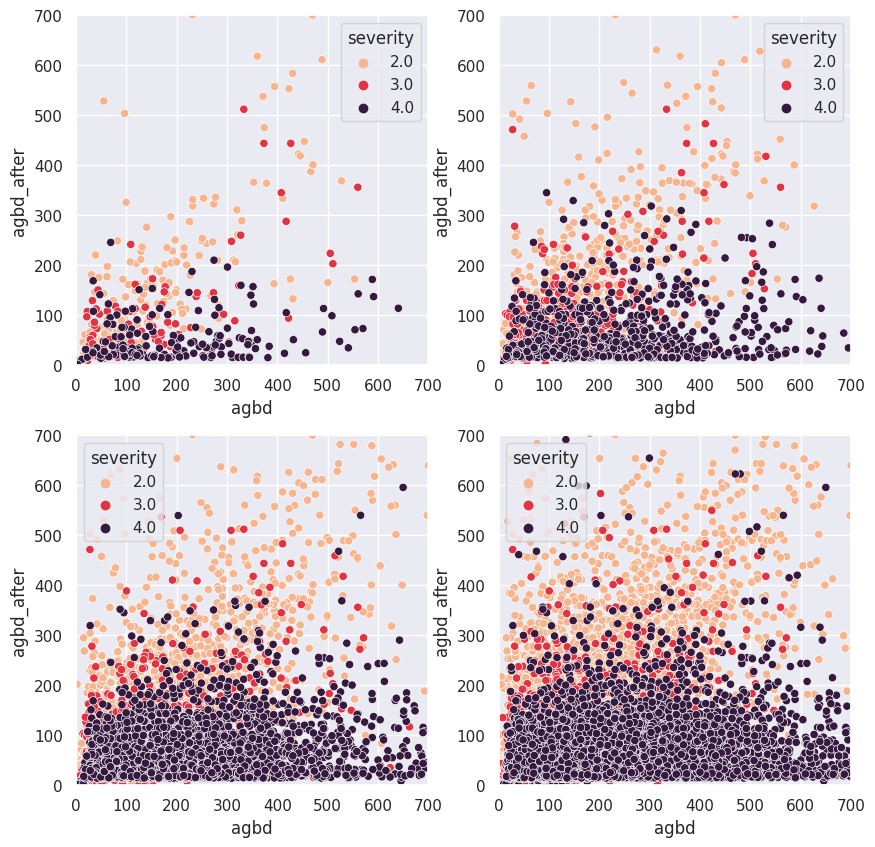

In [77]:
matching_analysis.plot_severity_for_distance(burn_agbd_matches_3x3, 'agbd')

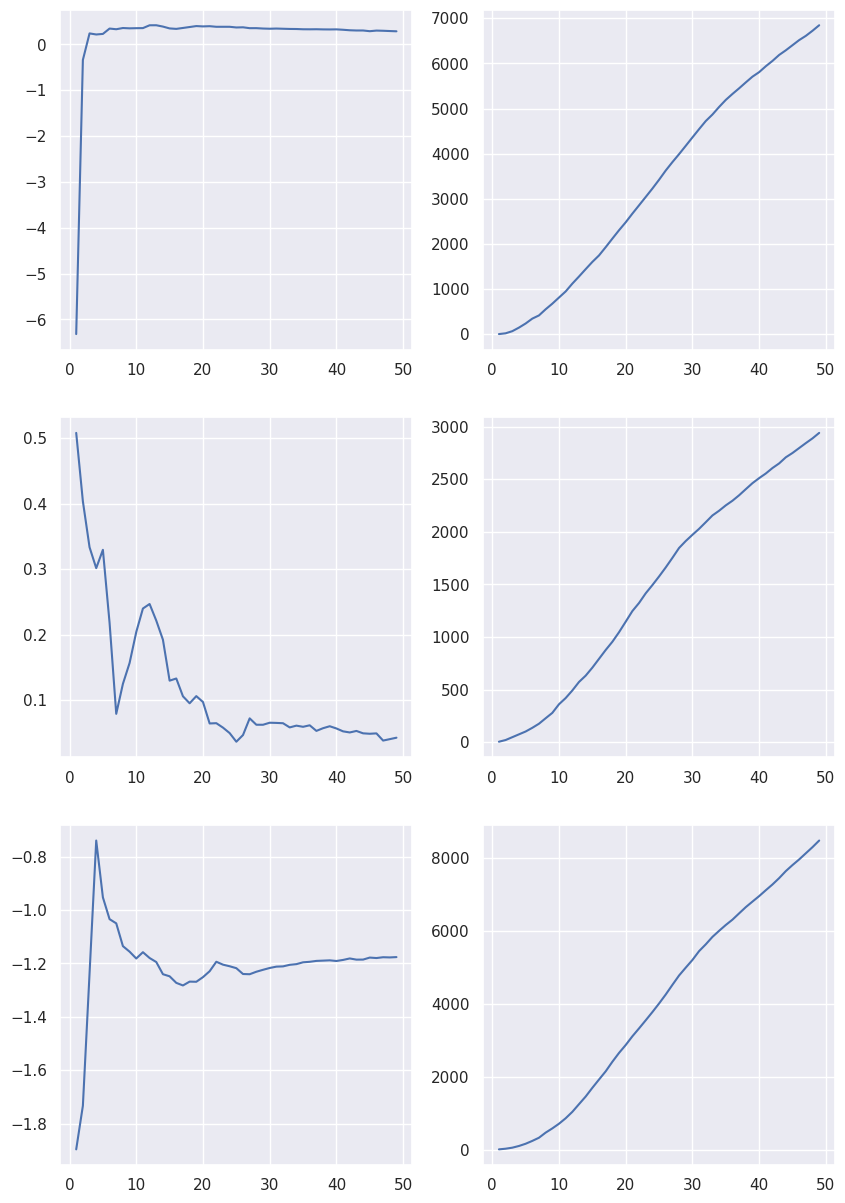

In [78]:
matching_analysis.plot_error_for_distances(burn_agbd_matches_3x3, 'agbd')

Linear regression fit for severity 2.
Best Linear regression coefficient is [0.71307624].         R squared is : 0.4940906719718763.
The error for coeff = 1 is: 0.39343950274741646.
Linear regression fit for severity 3.
Best Linear regression coefficient is [0.39816948].         R squared is : 0.2831427362444181.
The error for coeff = 1 is: 0.0970869022901708.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.08284944].         R squared is : 0.050307973212211254.
The error for coeff = 1 is: -1.2512432289692215.


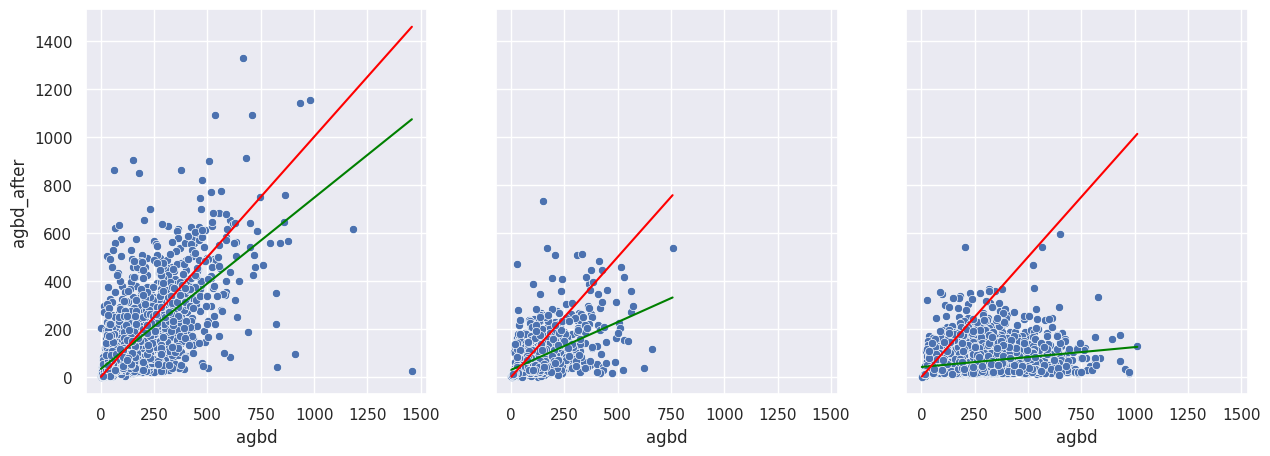

In [79]:
close_matches = burn_agbd_matches_3x3[burn_agbd_matches_3x3.closest_distance < 20]
matching_analysis.fit_linear_regression_per_severity(close_matches, 'agbd')

(-500.0, 500.0)

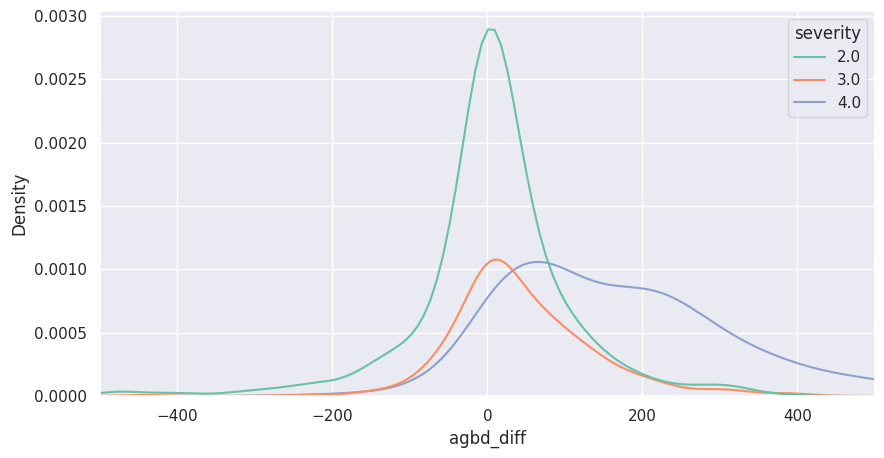

In [103]:
#close_matches = pd.concat((get_matches(burn_agbd_matches_3x3, 10), get_matches(matches, 10).sample(5000)))
close_matches = get_matches(burn_agbd_matches_3x3, 10)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.kdeplot(close_matches, x="agbd_diff", ax=ax, hue="severity", palette="Set2")
ax.set_xlim((-500, 500))

(-500.0, 500.0)

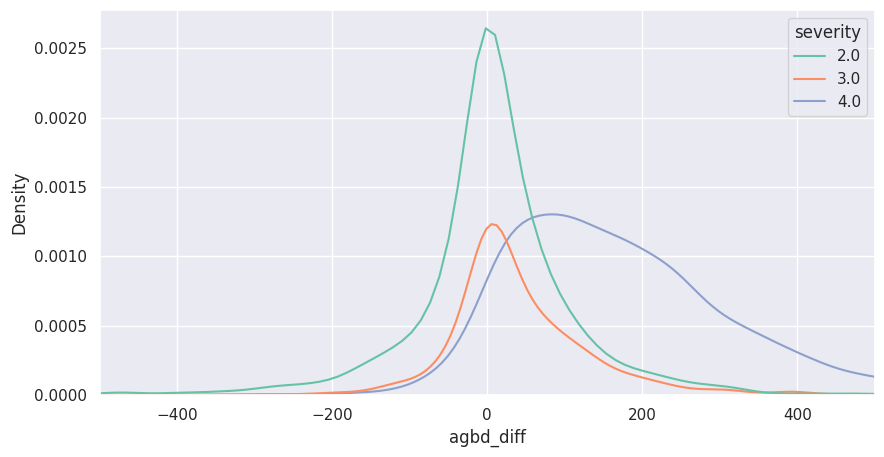

In [107]:
#close_matches = pd.concat((get_matches(burn_agbd_matches_3x3, 10), get_matches(matches, 10).sample(5000)))
close_matches = get_matches(burn_agbd_matches_3x3, 20)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.kdeplot(close_matches, x="agbd_diff", ax=ax, hue="severity", palette="Set2")
ax.set_xlim((-500, 500))

(-500.0, 500.0)

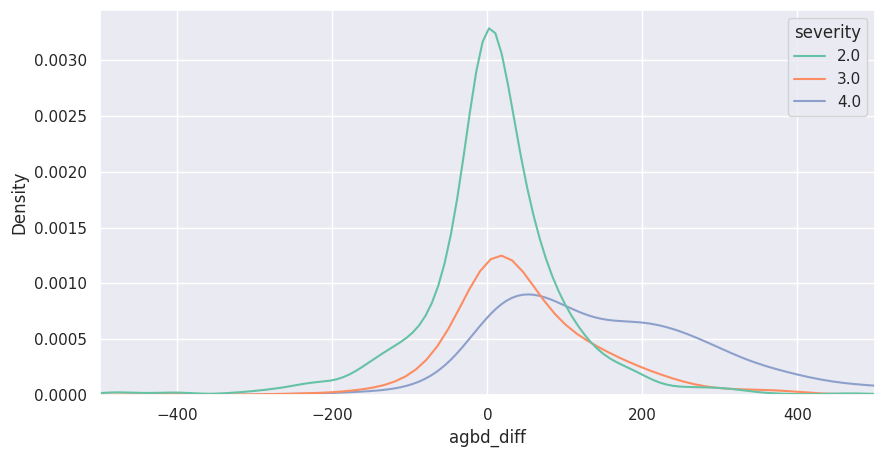

In [108]:
#close_matches = pd.concat((get_matches(burn_agbd_matches_3x3, 10), get_matches(matches, 10).sample(5000)))
close_matches = get_matches(burn_agbd_matches_2x2, 10)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.kdeplot(close_matches, x="agbd_diff", ax=ax, hue="severity", palette="Set2")
ax.set_xlim((-500, 500))

(-500.0, 500.0)

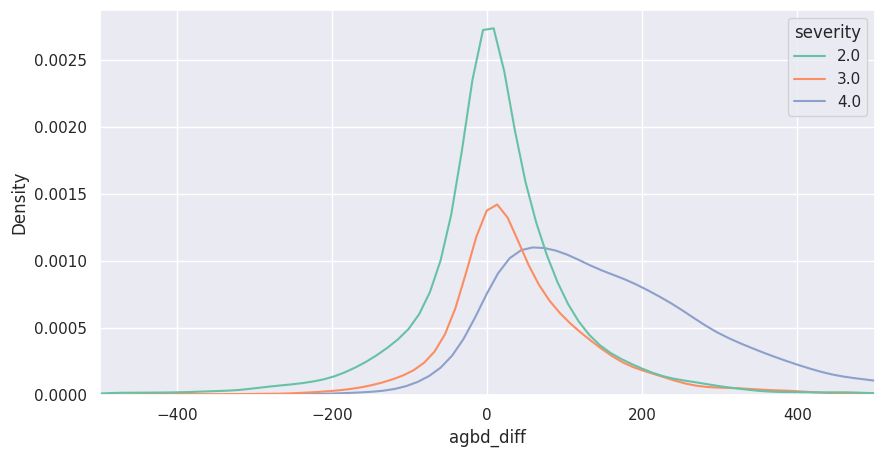

In [109]:
#close_matches = pd.concat((get_matches(burn_agbd_matches_3x3, 10), get_matches(matches, 10).sample(5000)))
close_matches = get_matches(burn_agbd_matches_2x2, 20)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.kdeplot(close_matches, x="agbd_diff", ax=ax, hue="severity", palette="Set2")
ax.set_xlim((-500, 500))

(-500.0, 500.0)

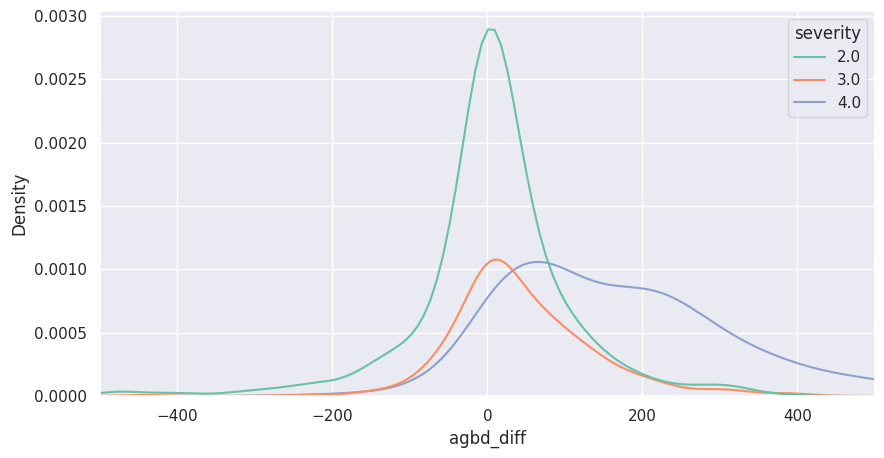

In [82]:
close_matches = burn_agbd_matches_3x3[burn_agbd_matches_3x3.closest_distance < 10]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.kdeplot(close_matches, x="agbd_diff", ax=ax, hue="severity", palette="Set2")
ax.set_xlim((-500, 500))

Linear regression fit for severity 2.
Best Linear regression coefficient is [0.7398752].         R squared is : 0.5136498505953042.
The error for coeff = 1 is: 0.41104639429531187.
Linear regression fit for severity 3.
Best Linear regression coefficient is [0.35528459].         R squared is : 0.21738447080997214.
The error for coeff = 1 is: -0.010972494961028367.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.11746452].         R squared is : 0.06863461163773932.
The error for coeff = 1 is: -1.0143721871878637.


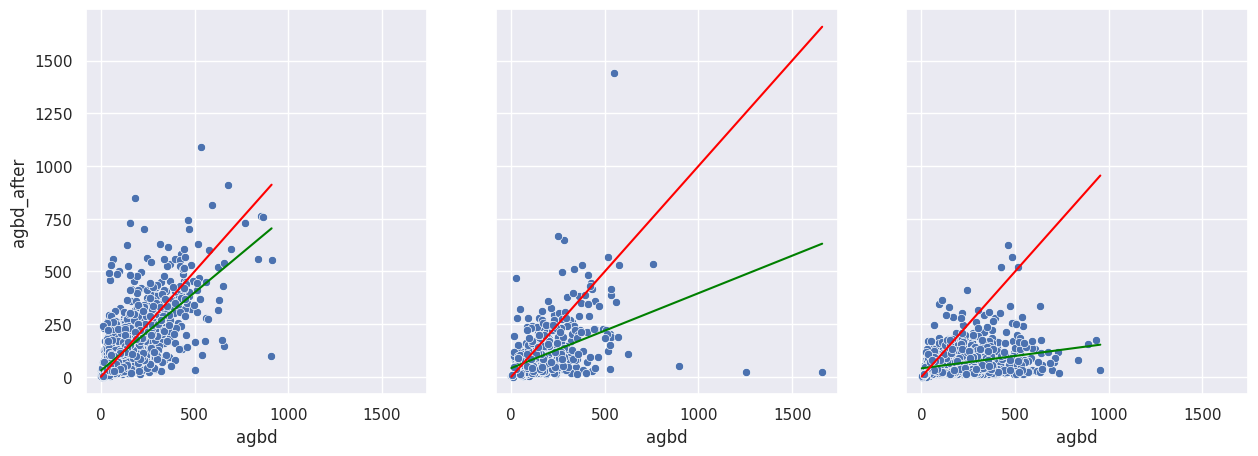

In [110]:
matching_analysis.fit_linear_regression_per_severity(get_matches(burn_agbd_matches_2x2, 10), 'agbd')

Linear regression fit for severity 0.
Best Linear regression coefficient is [0.76824845].         R squared is : 0.5959173304355856.
The error for coeff = 1 is: 0.5454242271350829.
Linear regression fit for severity 2.
Best Linear regression coefficient is [0.7398752].         R squared is : 0.5136498505953042.
The error for coeff = 1 is: 0.41104639429531187.
Linear regression fit for severity 3.
Best Linear regression coefficient is [0.35528459].         R squared is : 0.21738447080997214.
The error for coeff = 1 is: -0.010972494961028367.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.11746452].         R squared is : 0.06863461163773932.
The error for coeff = 1 is: -1.0143721871878637.


Text(0.5, 0, 'Pre-disturbance AGBD')

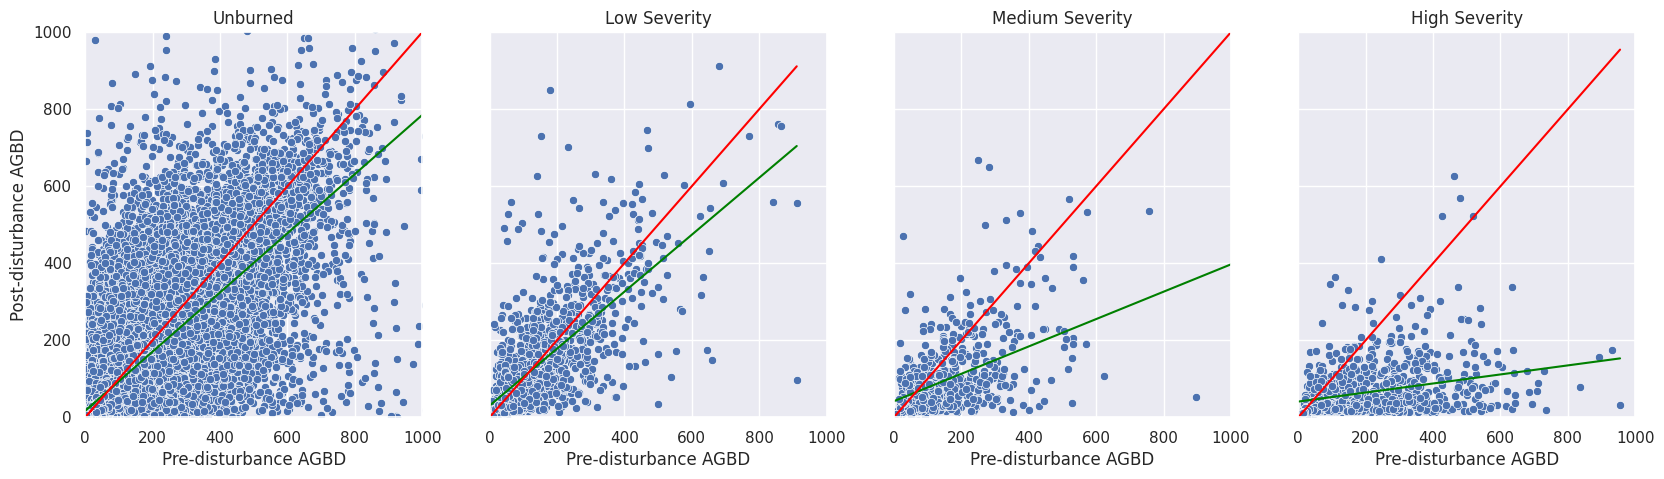

In [134]:
#combined = pd.concat([get_matches(matches, 10).sample(1000), get_matches(burn_agbd_matches_2x2, 10).sample(1000)])
combined = pd.concat([get_matches(matches, 10), get_matches(burn_agbd_matches_2x2, 10)])
fig, ax = matching_analysis.fit_linear_regression_per_severity_with_unburned(combined, 'agbd')
ax[0].set_title("Unburned")
ax[1].set_title("Low Severity")
ax[2].set_title("Medium Severity")
ax[3].set_title("High Severity")

'''
ax[0].text(x=10, y=950, s=f"Best fit: 0.77", fontsize=14, color="green")
ax[0].text(x=10, y=900, s=f"R^2: 0.54", fontsize=14, color="red")
ax[1].text(x=10, y=950, s=f"Best fit: 0.71", fontsize=14, color="green")
ax[1].text(x=10, y=900, s=f"R^2: 0.41", fontsize=14, color="red")
ax[2].text(x=10, y=950, s=f"Best fit: 0.36", fontsize=14, color="green")
ax[2].text(x=10, y=900, s=f"R^2: -0.01", fontsize=14, color="red")
ax[3].text(x=10, y=950, s=f"Best fit: 0.11", fontsize=14, color="green")
ax[3].text(x=10, y=900, s=f"R^2: -1.02", fontsize=14, color="red")
'''

ax[0].set_ylabel('Post-disturbance AGBD')
ax[0].set_xlabel('Pre-disturbance AGBD')
ax[1].set_xlabel('Pre-disturbance AGBD')
ax[2].set_xlabel('Pre-disturbance AGBD')
ax[3].set_xlabel('Pre-disturbance AGBD')

### Fit distributions to each severity category

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  6.56it/s]


         sumsquare_error          aic           bic  kl_div  ks_statistic  \
norm            0.000050  4978.808606 -76755.275037     inf      0.129713   
beta            0.000050  4977.291573 -76737.294943     inf      0.129334   
gamma           0.000051  4729.838397 -76630.026550     inf      0.141440   
burr            0.000090  4856.032653 -74260.207004     inf      0.245318   
lognorm         0.000193  1998.216120 -71036.297934     inf      0.791504   

             ks_pvalue  
norm      3.685625e-62  
beta      8.476569e-62  
gamma     7.078843e-74  
burr     2.202251e-223  
lognorm   0.000000e+00  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 27.41it/s]


{'norm': {'loc': 9.64031775168901, 'scale': 122.59934844349164}}


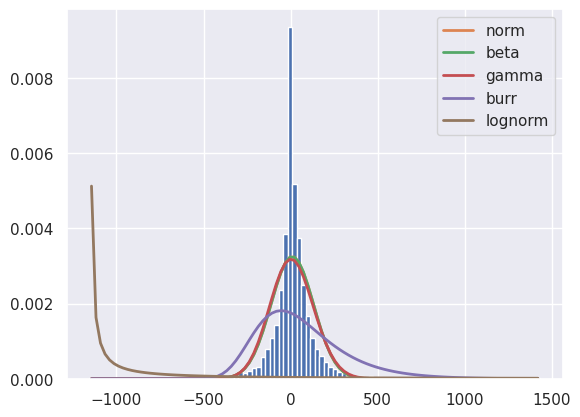

In [136]:
close_matches = get_matches(burn_agbd_matches_2x2, 20)
low = close_matches[close_matches.severity == 2]
matching_analysis.fit_distributions(low, 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]


         sumsquare_error          aic           bic  kl_div  ks_statistic  \
lognorm         0.000044  4812.700676 -41358.048380     inf      0.125863   
beta            0.000045  4929.593651 -41309.344306     inf      0.126379   
norm            0.000048  5550.129981 -41185.327774     inf      0.125237   
burr            0.000073  4373.326680 -40186.486179     inf      0.195107   
gamma           0.000166          inf -38275.500745     inf      0.998710   

            ks_pvalue  
lognorm  1.364055e-32  
beta     7.408902e-33  
norm     2.849636e-32  
burr     4.427870e-78  
gamma    0.000000e+00  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 29.20it/s]


{'norm': {'loc': 47.16458317093138, 'scale': 120.37577447692011}}


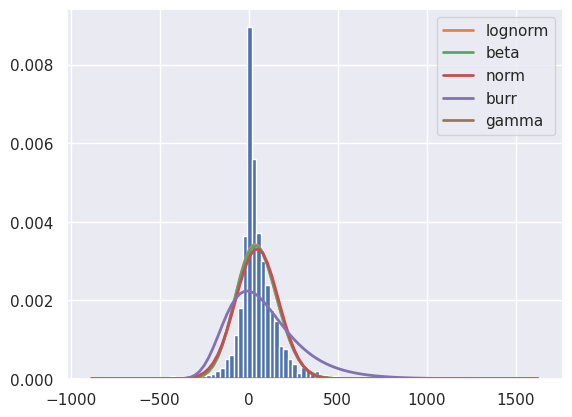

In [137]:
close_matches = get_matches(burn_agbd_matches_2x2, 20)
medium = close_matches[close_matches.severity == 3]
matching_analysis.fit_distributions(medium, 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]


         sumsquare_error           aic           bic  kl_div  ks_statistic  \
gamma           0.000004           inf -75168.163946     inf      0.048827   
beta            0.000008  5.251215e+03 -72438.518047     inf      0.078238   
norm            0.000008  4.944716e+03 -72358.867277     inf      0.078201   
burr            0.000029  1.068123e+04 -67616.949528     inf      0.229006   
lognorm         0.000098  2.031618e+03 -63230.039502     inf      0.816368   

             ks_pvalue  
gamma     5.865927e-08  
beta      9.089079e-20  
norm      9.485866e-20  
burr     8.976225e-168  
lognorm   0.000000e+00  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 26.47it/s]


{'norm': {'loc': 165.02834109532074, 'scale': 158.1718866707418}}


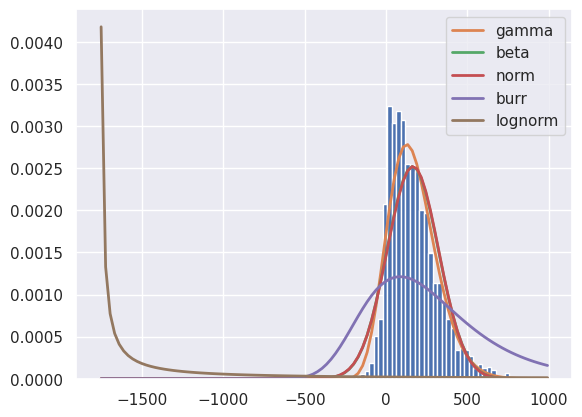

In [138]:
close_matches = get_matches(burn_agbd_matches_2x2, 20)
high = close_matches[close_matches.severity == 4]
matching_analysis.fit_distributions(high, 'agbd')

(-500.0, 500.0)

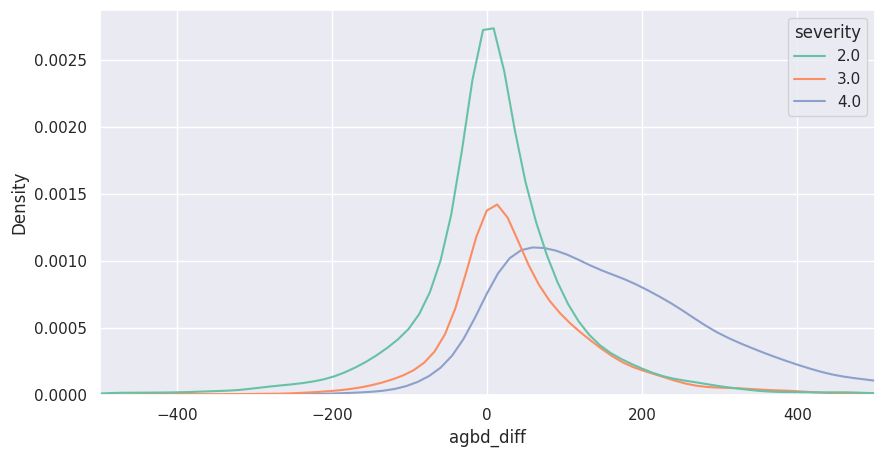

In [139]:
close_matches = get_matches(burn_agbd_matches_2x2, 20)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.kdeplot(close_matches, x="agbd_diff", ax=ax, hue="severity", palette="Set2")
ax.set_xlim((-500, 500))